# Azure OpenAI Batch on local images

The Azure OpenAI Batch API is designed to handle large-scale and high-volume processing tasks efficiently. **Process asynchronous groups of requests with separate quota, with 24-hour target turnaround, at 50% less cost than global standard.** With batch processing, rather than send one request at a time you send a large number of requests in a single file. Global batch requests have a separate enqueued token quota avoiding any disruption of your online workloads.

Key use cases include:
- Large-Scale Data Processing: Quickly analyze extensive datasets in parallel.
- Content Generation: Create large volumes of text, such as product descriptions or articles.
- Document Review and Summarization: Automate the review and summarization of lengthy documents.
- Customer Support Automation: Handle numerous queries simultaneously for faster responses.
- Data Extraction and Analysis: Extract and analyze information from vast amounts of unstructured data.
- Natural Language Processing (NLP) Tasks: Perform tasks like sentiment analysis or translation on large datasets.
- Marketing and Personalization: Generate personalized content and recommendations at scale.

https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/batch

In [1]:
import base64
import datetime
import glob
import json
import openai
import os
import sys
import time

from dotenv import load_dotenv
from IPython.display import Image
from openai import AzureOpenAI
from PIL import Image as PILImage

In [2]:
print(f"Python version: {sys.version}")
print(f"OpenAI version: {openai.__version__}")

Python version: 3.10.11 (main, May 16 2023, 00:28:57) [GCC 11.2.0]
OpenAI version: 1.43.0


In [3]:
print(f"Today is {datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today is 06-Sep-2024 08:52:23


## Settings

In [4]:
load_dotenv("azure.env")

# Azure OpenAI   
AZURE_OPENAI_API_ENDPOINT: str = os.getenv("AZURE_OPENAI_API_ENDPOINT")
AZURE_OPENAI_API_KEY: str = os.getenv("AZURE_OPENAI_API_KEY")

AOAI_BATCH_MODEL: str = "gpt-4o-batch"

In [5]:
JSONL_DIR = "jsonl"
RESULTS_DIR = "results"

os.makedirs(JSONL_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

## Creating some prompts

In [6]:
# Template for the JSONL content
template = {
    "custom_id": "request-{}",
    "method": "POST",
    "url": "/chat/completions",
    "body": {
        "model": AOAI_BATCH_MODEL,
        "messages": [
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": [
                {"type": "text", "text": "What’s in this image?"},
                {"type": "image_url", "image_url": {"url": ""}}
            ]}
        ],
        "max_tokens": 2000
    }
}

### Downloading some images

In [7]:
os.makedirs("images", exist_ok=True)

In [8]:
!wget "https://raw.githubusercontent.com/retkowsky/Azure-Computer-Vision-in-a-day-workshop/main/images/postalcard.jpg" -O "images/image1.jpg"
!wget "https://raw.githubusercontent.com/retkowsky/Azure-Computer-Vision-in-a-day-workshop/main/images/street.jpg" -O "images/image2.jpg"
!wget "https://raw.githubusercontent.com/retkowsky/Azure-Computer-Vision-in-a-day-workshop/main/images/drinks.jpg" -O "images/image3.jpg"

--2024-09-06 08:52:23--  https://raw.githubusercontent.com/retkowsky/Azure-Computer-Vision-in-a-day-workshop/main/images/postalcard.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94814 (93K) [image/jpeg]
Saving to: ‘images/image1.jpg’

images/image1.jpg   100%[===================>]  92.59K  --.-KB/s    in 0.002s  

2024-09-06 08:52:23 (52.4 MB/s) - ‘images/image1.jpg’ saved [94814/94814]

--2024-09-06 08:52:23--  https://raw.githubusercontent.com/retkowsky/Azure-Computer-Vision-in-a-day-workshop/main/images/street.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request s

In [9]:
!ls images/*.* -lh

-rwxrwxrwx 1 root root  93K Sep  6 08:52 images/image1.jpg
-rwxrwxrwx 1 root root 331K Sep  6 08:52 images/image2.jpg
-rwxrwxrwx 1 root root 224K Sep  6 08:52 images/image3.jpg


In [10]:
image_files_list = glob.glob(os.path.join("images", '*.jpg'))
image_files_list

['images/image1.jpg', 'images/image2.jpg', 'images/image3.jpg']

## Images

1 Image file: images/image1.jpg


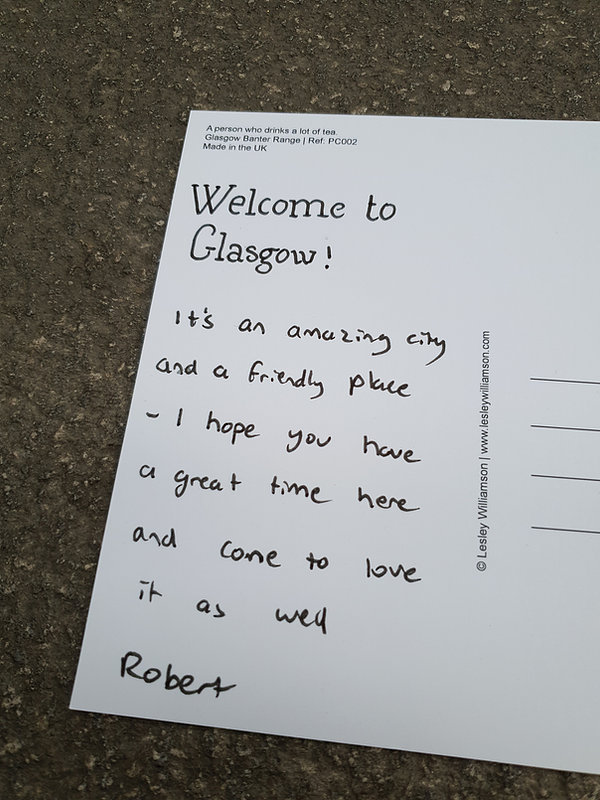

2 Image file: images/image2.jpg


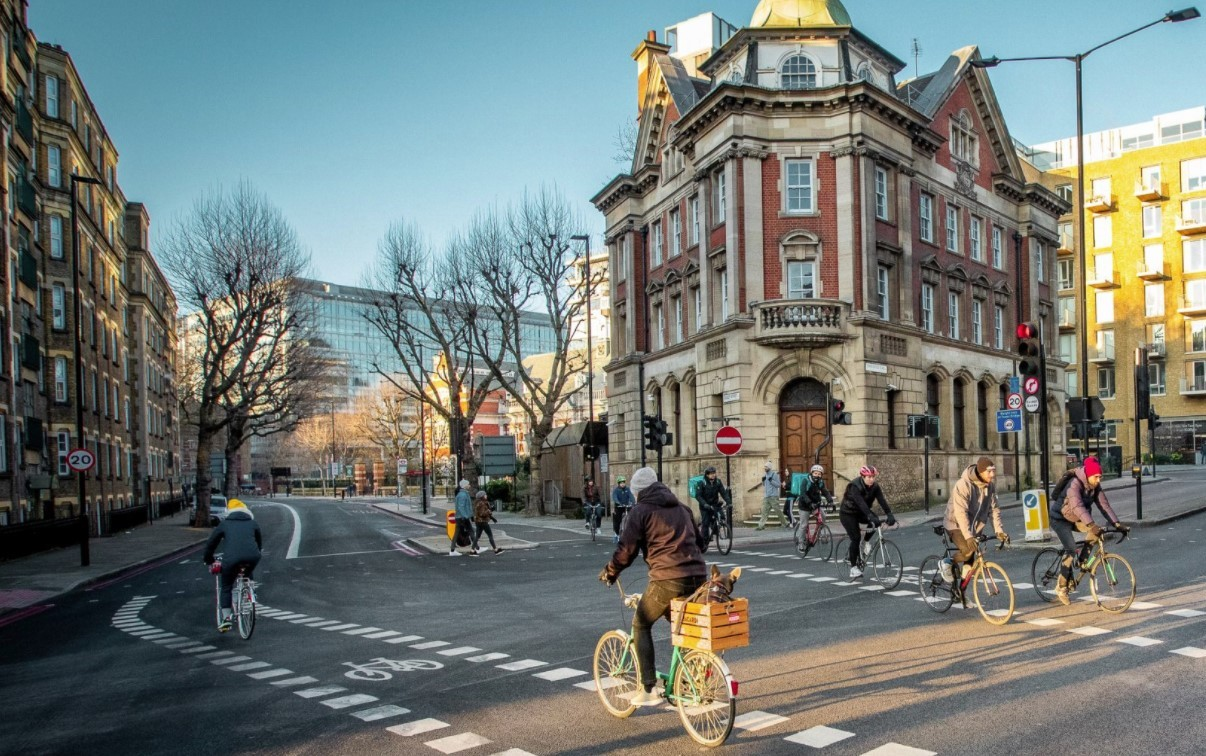

3 Image file: images/image3.jpg


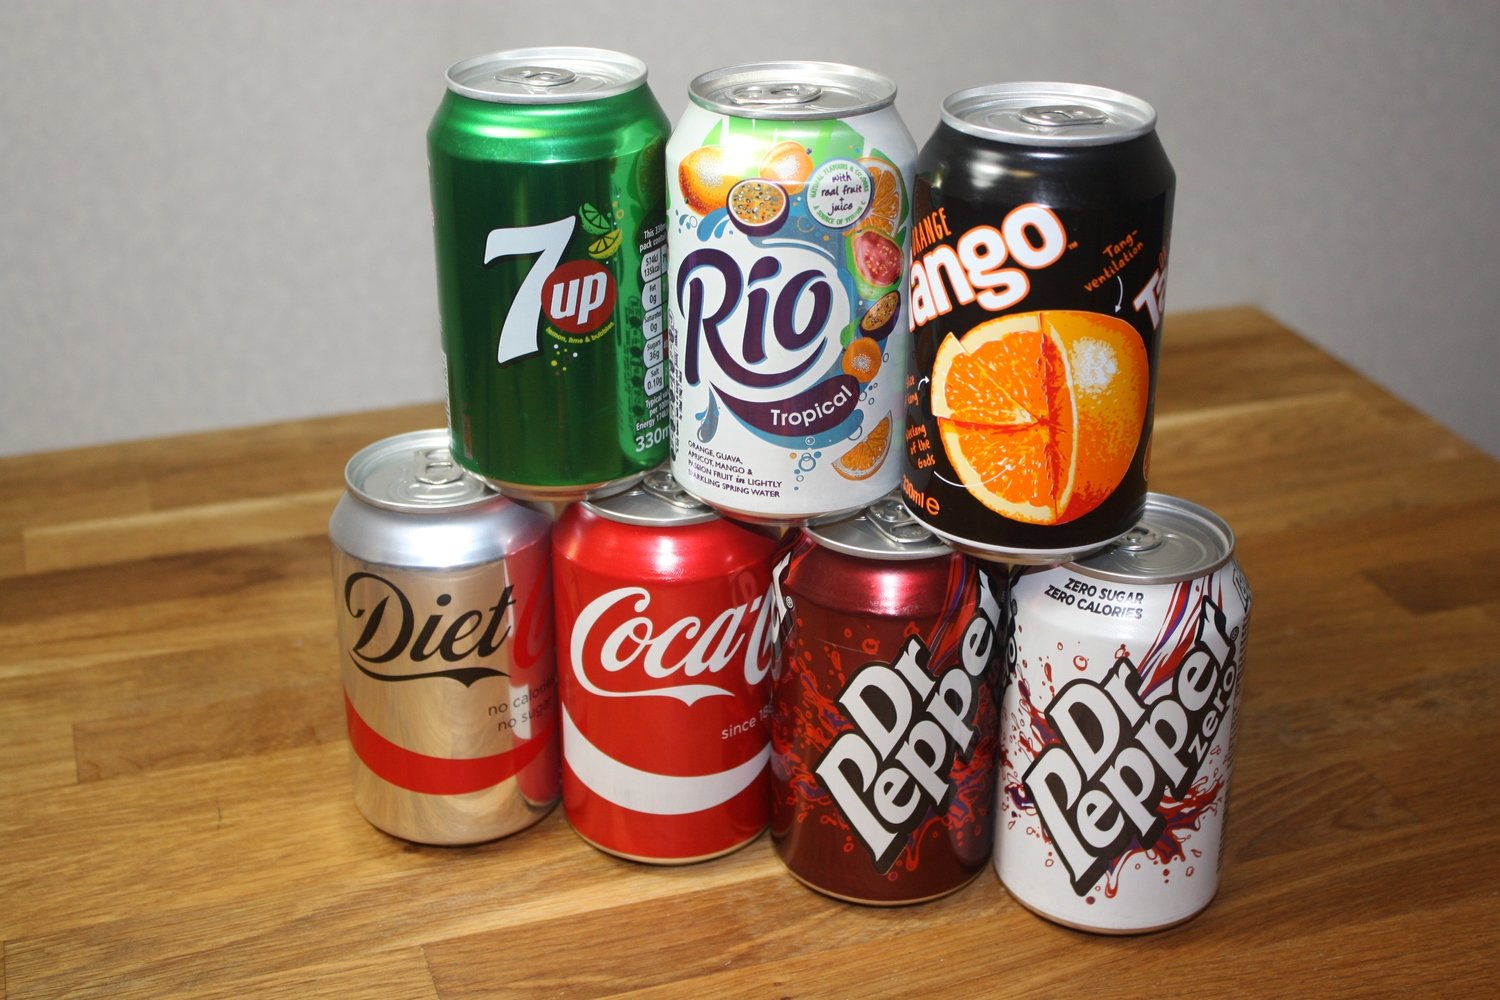

In [11]:
for idx, image in enumerate(image_files_list, start=1):
    print(f"{idx} Image file: {image}")
    display(Image(filename=image))

## Creating the jsonl input file for batch

In [12]:
# File to create
jsonlfile = os.path.join(JSONL_DIR, "batch_local_images.jsonl")

In [13]:
def image_to_base64(image_path):
    """
    image to base64
    """
    with open(image_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode("utf-8")
    
    return encoded_string

In [14]:
def create_jsonl_content(image64, request_id):
    """
    Creating jsonl content
    """
    template = {
        "custom_id": f"request-{request_id}",
        "method": "POST",
        "url": "/chat/completions",
        "body": {
            "model": AOAI_BATCH_MODEL,
            "messages": [
                {"role": "system", "content": "You are an AI helpful assistant."},
                {"role": "user", "content": [
                    {"type": "text", "text": "Describe this image"},
                    {"type": "image_url", "image_url": {"url": image64}}
                ]}
            ],
            "max_tokens": 2000
        }
    }
    return json.dumps(template)

In [15]:
with open(jsonlfile, 'w') as file:
    # Iterate through each image URL
    for i, image in enumerate(image_files_list, start=1):
        base64_string = image_to_base64(image)
        image_64 = f"data:image/jpeg;base64,{base64_string}"
        jsonl_content = create_jsonl_content(image_64, i)
        file.write(jsonl_content + "\n")  # Write each JSON object on a new line

    print(f"Created file: {jsonlfile}")

Created file: jsonl/batch_local_images.jsonl


In [16]:
!ls $jsonlfile -lh

-rwxrwxrwx 1 root root 863K Sep  6 08:52 jsonl/batch_local_images.jsonl


In [17]:
with open(jsonlfile, 'r') as file:
    content = file.read()

## Azure OpenAI

In [18]:
client = AzureOpenAI(
    api_key=AZURE_OPENAI_API_KEY,  
    api_version="2024-07-01-preview",
    azure_endpoint = AZURE_OPENAI_API_ENDPOINT,
    )

## Upload batch file

In [19]:
# Upload a file with a purpose of "batch"
file = client.files.create(
  file=open(jsonlfile, "rb"), 
  purpose="batch"
)

print("\033[1;34m")
print(file.model_dump_json(indent=2))
file_id = file.id


{
  "id": "file-c72f183818804f888a6a32ef4335ad18",
  "bytes": 883379,
  "created_at": 1725612746,
  "filename": "batch_local_images.jsonl",
  "object": "file",
  "purpose": "batch",
  "status": "pending",
  "status_details": null
}


## Track file upload status

In [20]:
status = "pending"

print("\033[1;34m")

while status != "processed":
    time.sleep(10)
    file_response = client.files.retrieve(file_id)
    status = file_response.status
    print(f"{datetime.datetime.now()} | File Id: {file_id} | Status: {status}")
    
print(f"{datetime.datetime.now()} End")


2024-09-06 08:52:36.916857 | File Id: file-c72f183818804f888a6a32ef4335ad18 | Status: processed
2024-09-06 08:52:36.917124 End


## Create batch job

In [21]:
# Submit a batch job with the file
batch_response = client.batches.create(
    input_file_id=file_id,
    endpoint="/chat/completions",
    completion_window="24h",
)

# Save batch ID for later use
batch_id = batch_response.id

print("\033[1;34m")
print(batch_response.model_dump_json(indent=2))


{
  "id": "batch_9c5a784d-83af-4923-88fa-a7bc198190ff",
  "completion_window": "24h",
  "created_at": 1725612757,
  "endpoint": "/chat/completions",
  "input_file_id": "file-c72f183818804f888a6a32ef4335ad18",
  "object": "batch",
  "status": "validating",
  "cancelled_at": null,
  "cancelling_at": null,
  "completed_at": null,
  "error_file_id": null,
  "errors": null,
  "expired_at": null,
  "expires_at": 1725699157,
  "failed_at": null,
  "finalizing_at": null,
  "in_progress_at": null,
  "metadata": null,
  "output_file_id": null,
  "request_counts": {
    "completed": 0,
    "failed": 0,
    "total": 0
  }
}


## Track batch job progress

In [22]:
status = "validating"

start = time.time()

status_colors = {
    "validating": "\033[1;31;30m",
    "in_progress": "\033[1;31;34m",
    "finalizing": "\033[1;31;32m",
    "completed":"\033[1;31;35m",
}

while status not in ("completed", "failed", "canceled"):
    time.sleep(30)
    batch_response = client.batches.retrieve(batch_id)
    status = batch_response.status
    print(status_colors.get(status, ""), end="")
    print(f"{datetime.datetime.now()} | Batch Id: {batch_id} | Status: {status}")
    
elapsed = time.time() - start
minutes, seconds = divmod(elapsed, 60)
print("\033[0m")
print(f"Elapsed time = {minutes:.0f} minutes and {seconds:.0f} seconds")

2024-09-06 08:53:08.710682 | Batch Id: batch_9c5a784d-83af-4923-88fa-a7bc198190ff | Status: validating
2024-09-06 08:53:39.711921 | Batch Id: batch_9c5a784d-83af-4923-88fa-a7bc198190ff | Status: validating
2024-09-06 08:54:10.284605 | Batch Id: batch_9c5a784d-83af-4923-88fa-a7bc198190ff | Status: validating
2024-09-06 08:54:40.787548 | Batch Id: batch_9c5a784d-83af-4923-88fa-a7bc198190ff | Status: in_progress
2024-09-06 08:55:11.232529 | Batch Id: batch_9c5a784d-83af-4923-88fa-a7bc198190ff | Status: in_progress
2024-09-06 08:55:41.718962 | Batch Id: batch_9c5a784d-83af-4923-88fa-a7bc198190ff | Status: in_progress
2024-09-06 08:56:12.177623 | Batch Id: batch_9c5a784d-83af-4923-88fa-a7bc198190ff | Status: in_progress
2024-09-06 08:56:42.697926 | Batch Id: batch_9c5a784d-83af-4923-88fa-a7bc198190ff | Status: in_progress
2024-09-06 08:57:13.301043 | Batch Id: batch_9c5a784d-83af-4923-88fa-a7bc198190ff | Status: in_progress
2024-09-06 08:57:43.792118 | Batch Id: batch_9c5a784d-83af-4923-88f

## Retrieve batch job output file

In [23]:
%%javascript Python 
OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

In [24]:
# Retrieve the file content
file_response = client.files.content(batch_response.output_file_id)
raw_responses = file_response.text.strip().split('\n')

# Set text color to blue
print("\033[1;34m")

formatted_json_list = []

for raw_response in raw_responses:
    try:
        # Parse the JSON string
        parsed_json = json.loads(raw_response)
        formatted_json_list.append(parsed_json)
        # Format the JSON with indentation
        formatted_json = json.dumps(parsed_json, indent=5)
        # Print the formatted JSON
        print(formatted_json)
    
    except json.JSONDecodeError as e:
        # Handle the case where a line isn't valid JSON
        print(f"Error decoding JSON: {e}")


{
     "custom_id": "request-1",
     "response": {
          "body": {
               "choices": [
                    {
                         "content_filter_results": {
                              "hate": {
                                   "filtered": false,
                                   "severity": "safe"
                              },
                              "protected_material_code": {
                                   "filtered": false,
                                   "detected": false
                              },
                              "protected_material_text": {
                                   "filtered": false,
                                   "detected": false
                              },
                              "self_harm": {
                                   "filtered": false,
                                   "severity": "safe"
                              },
                              "sexual": {
                 

## Saving batch job output file

In [25]:
result_file = os.path.join(RESULTS_DIR, "batch_local_images_results.json")

with open(result_file, 'w') as output_file:
    json.dump(formatted_json_list, output_file, indent=5)

print(f"Results has been saved to {result_file}\n")

Results has been saved to results/batch_local_images_results.json



In [26]:
!ls $result_file -lh

-rwxrwxrwx 1 root root 15K Sep  6 09:00 results/batch_local_images_results.json


********** Result request-1 **********

Image file: images/image1.jpg


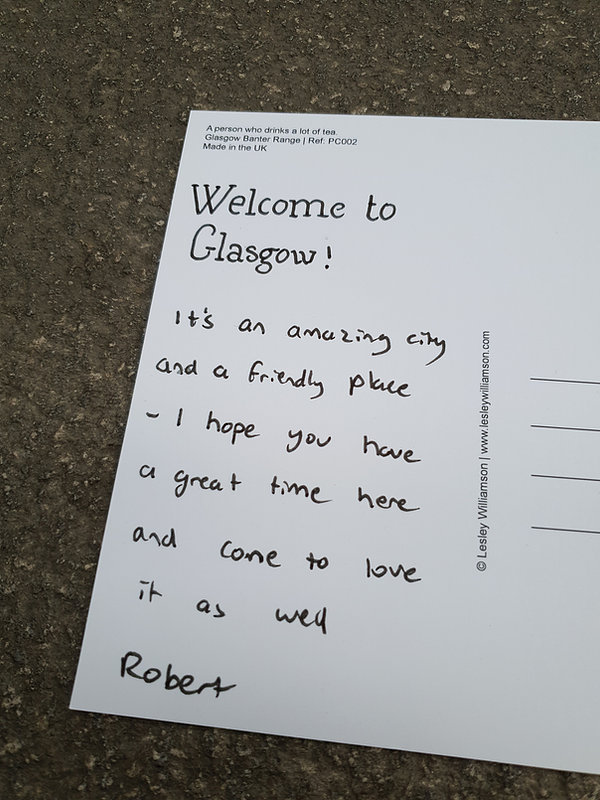

Answer: The image shows a handwritten postcard placed on a surface. The top part of the postcard has a printed message, which reads:

"Welcome to Glasgow!"

Below this, there is a handwritten message that says:

"It's an amazing city
and a friendly place
- I hope you have a great time here 
and come to love it as well

Robert"

The postcard also includes a small printed note in the top left corner that says:

"A person who drinks a lot of tea
Glasgow Banter Range | Ref: PC002
Made in the UK"

Additionally, there is a vertical text along the right edge of the postcard indicating the website and name "© Lesley Williamson | www.lesleywilliamson.com". The back of the postcard has lines for addressing and a space for a postage stamp.

********** Result request-2 **********

Image file: images/image2.jpg


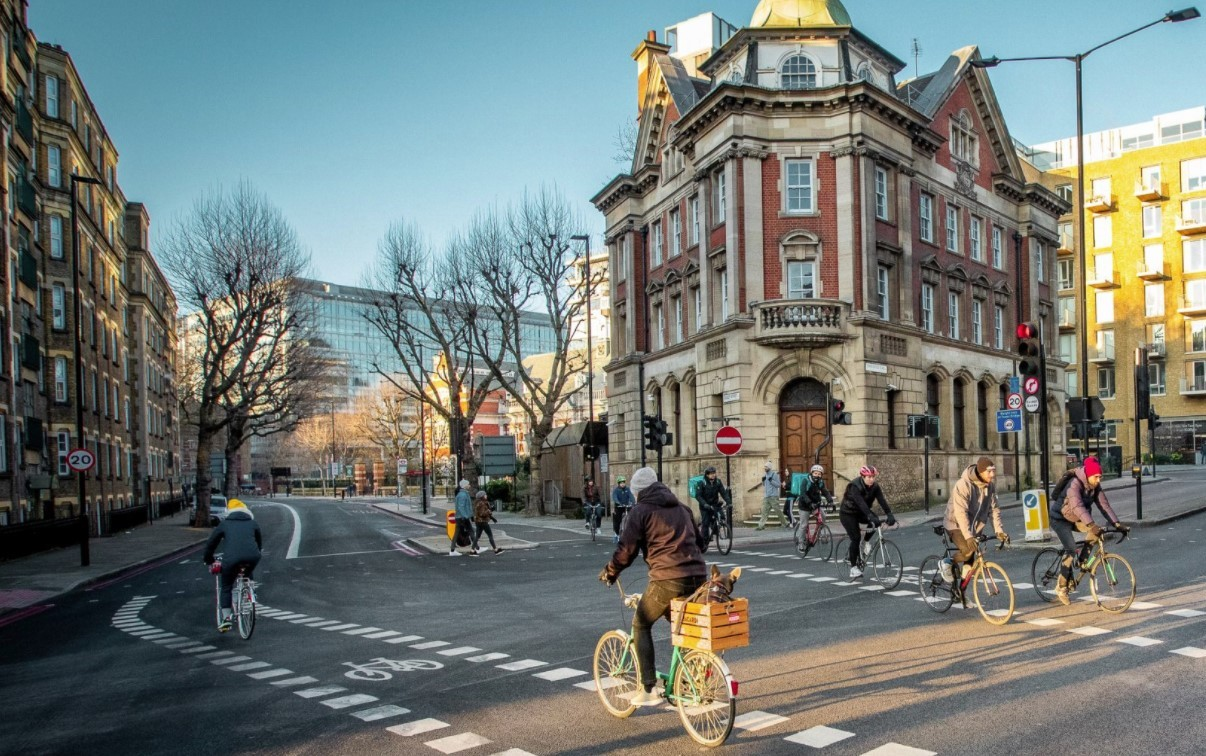

Answer: The image shows an urban street scene with several people riding bicycles. The focus is on a large, ornate building on the corner of the street, which has a classical architectural style featuring red brick and stone accents. The building has large windows and a prominent entrance.

The street is designated for cyclists, indicated by the bicycle lane markings and signage. It's a calm, clear day, with trees alongside the road likely in a dormancy stage since they have no leaves. The backdrop includes modern buildings with glass facades, blending historical and contemporary architectural styles. The scene exudes an atmosphere of active urban life, with individuals commuting and presumably enjoying their ride.

********** Result request-3 **********

Image file: images/image3.jpg


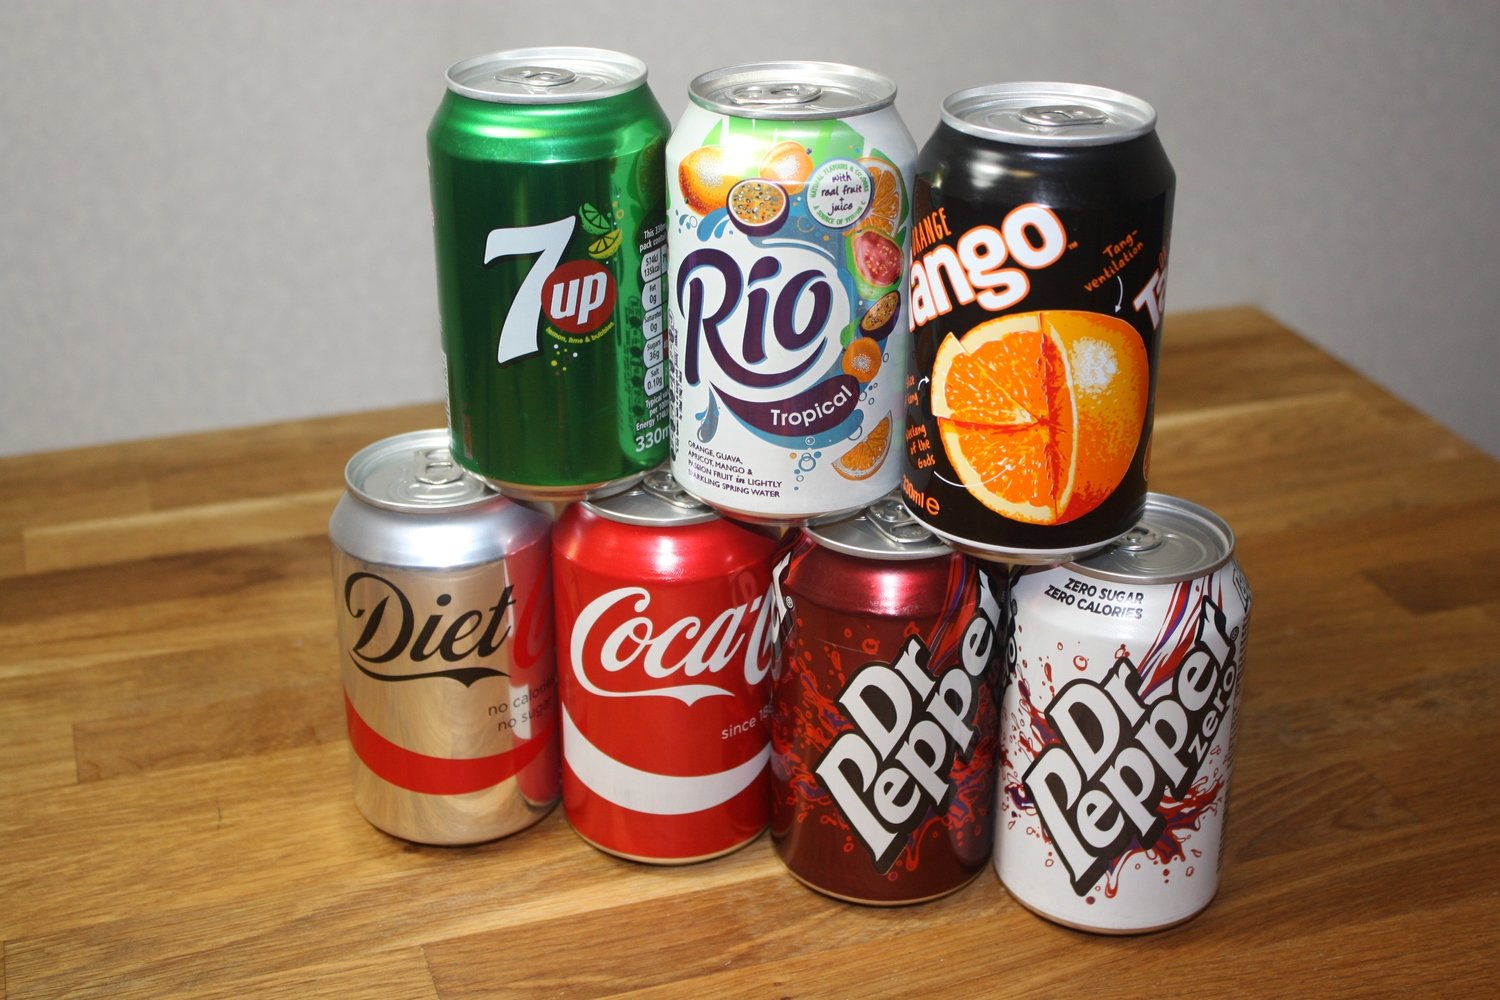

Answer: The image shows a collection of seven soda cans arranged in a pyramid-like structure on a wooden surface. The cans are from different brands and flavors. From the top down, the sodas are:

1. **Top row**: 
   - 7 Up (green can).
   - Rio Tropical (white can with fruit graphics).
   - Tango Orange (black can with orange fruit graphics).
   
2. **Middle row**:
   - Diet Coke (silver and red can).
   - Coca-Cola (red can).
   - Dr Pepper (burgundy-colored can).

3. **Bottom row**:
   - Dr Pepper Zero (white can with red and black graphics). 

The arrangement and variety showcase different flavors and brands of carbonated beverages.



In [27]:
# First, sort the data by custom_id
with open(result_file, 'r') as file:
    data = json.load(file)

sorted_data = sorted(data, key=lambda x: x["custom_id"])

# Print the results in alphabetical order of custom_id
for image_file, item in zip(image_files_list, sorted_data):
    customid = item["custom_id"]
    result = item["response"]["body"]["choices"][0]["message"]["content"]
    print(f"********** Result {customid} **********\n")
    print(f"Image file: {image_file}")
    display(PILImage.open(image_file))
    print(f"\033[1;31;34mAnswer: {result}\n\033[0m")